In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'

df = pd.read_csv(f'{data_dir}/study_373/top_5_373.csv')

# For dataset 373, the input data is blocked by year to avoid large jumps
train = [df[df['DATE'] < '2009'], df[df['DATE'].between('2009', '2010')], df[df['DATE'].between('2009', '2011')], df[df['DATE'].between('2011', '2012')]]
test = df[df['DATE'] >= '2012']

print(len(df))
print(len(test))
for d in train:
    print(len(d))

393
74
25
102
224
70


The general autoregressive models is:

$$AR(X_t) = \sum_{i = 0}^p \phi_i X_{t - i} + \epsilon$$

Where the $\phi_i$ are the learned parameters and $\epsilon$ is noise. For forcasting, we remove the $\epsilon$ and treat the output as the expected value at the next timestep.

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as parameterize

# We will use this to parameterize the weights of the model to be always positive
class logexp(nn.Module):
    def forward(self, X):
        return torch.exp(X)

class ARModel(nn.Module):

    def __init__(self, lag):
        super().__init__()

        # The basic autoregressive model is simply a linear combination of the last values
        self.output = nn.Linear(lag, 1)

        # We can require all weights to be positive using the above logexp module
        parameterize.register_parametrization(self.output, 'weight', logexp())
        self.lag = lag

    def forward(self, input):
        return self.output(input)
    
    def fit(self, data, iters = 100, verbose = False):
        # We will use 100 iterations of stochastic gradient descent with a learning rate
        # of 0.001
        optimizer = optim.SGD(self.parameters(), lr = 0.001)

        # Mean Square Error loss
        loss_fn = nn.MSELoss()

        # First generate the sequences of inputs and outputs in the proper tensor format
        input, output = [], []
        for i in range(self.lag, len(data)):
            input.append(torch.tensor(data[i - self.lag:i], dtype = torch.float32))
            output.append(torch.tensor([data[i]], dtype = torch.float32))

        for _ in range(iters):
            total_loss = 0
            for x, y in zip(input, output):
                # We need to zero the gradients for each optimization step
                optimizer.zero_grad()

                # Calculate the loss for this step
                pred = self.forward(x)
                loss = loss_fn(pred, y)
                total_loss += loss

                # Backpropagate the loss
                loss.backward()

                # Step the optimizer forward to update the parameters
                optimizer.step()
            if verbose: print(f'total loss: {total_loss:.4f}')


In [83]:
species = []

# Determine the species in this dataset
for c in df.columns:
    if c == 'DATE': continue
    species.append(c)  

# The lag for the AR Models, this is the number of previous instances
# that are used for each predictions
lag = 5

# We have an independent model for each species
model = { s : ARModel(lag) for s in species }

for s in species:
    # Train the species on the training datasets
    for table in train:
        data = table[s].tolist()
        model[s].fit(data, iters = 100)



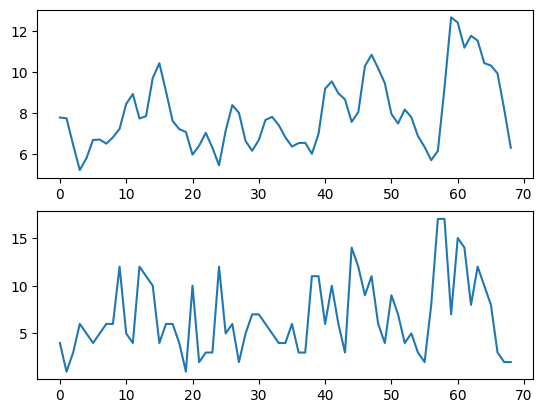

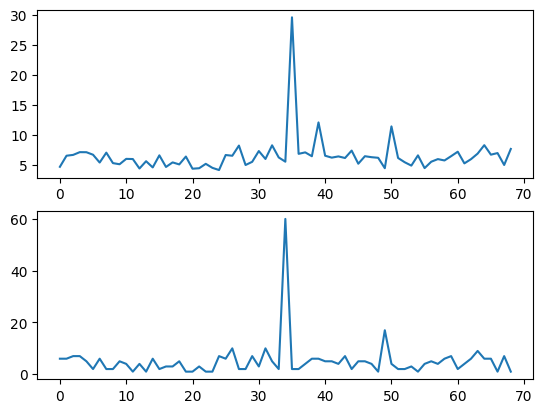

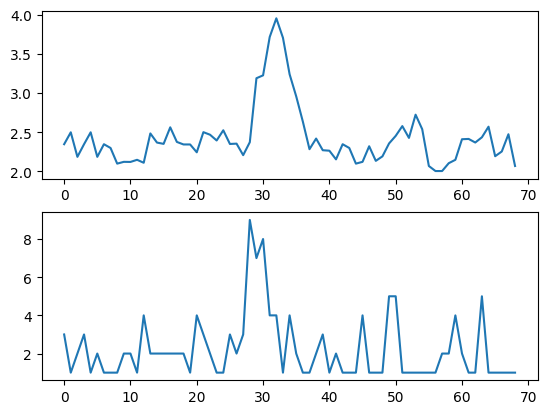

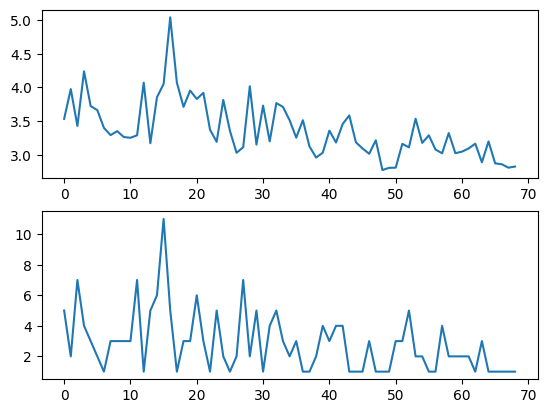

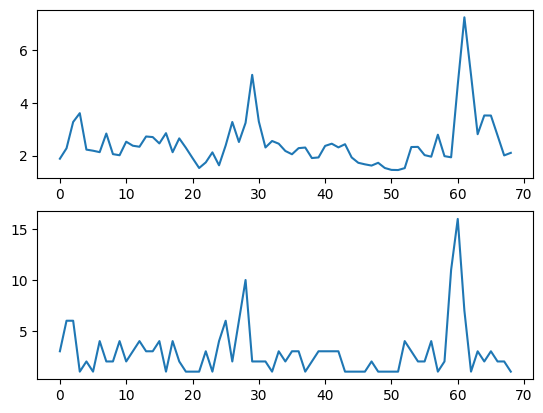

In [84]:
x = [i for i in range(len(test) - lag)]

data = { s : test[s].tolist() for s in species }

predictions = { s : [] for s in species }
expected = { s : [] for s in species }

for s in species:
    _, ax = plt.subplots(2)
    for i in range(lag, len(test)):
        input = torch.tensor(data[s][i - lag:i], dtype = torch.float32)
        expected[s].append(data[s][i])
        predictions[s].append(model[s].forward(input).item())

    ax[0].plot(x, predictions[s])
    ax[1].plot(x, expected[s])
    plt.show()

In [87]:
for s in model:
    display(model[s].output.weight)

tensor([[0.0082, 0.0152, 0.1567, 0.2811, 0.1754]], grad_fn=<ExpBackward0>)

tensor([[0.0979, 0.0160, 0.0367, 0.0232, 0.4244]], grad_fn=<ExpBackward0>)

tensor([[0.0161, 0.1174, 0.0624, 0.0433, 0.1001]], grad_fn=<ExpBackward0>)

tensor([[0.0537, 0.0453, 0.0441, 0.0278, 0.1686]], grad_fn=<ExpBackward0>)

tensor([[0.0967, 0.0237, 0.0294, 0.1018, 0.2995]], grad_fn=<ExpBackward0>)